In [190]:
#MMedLLama Inference
import os
import json
import datetime
import pandas as pd
from tqdm import tqdm
from openai import OpenAI   # vLLM client
import tiktoken  # For token counting

# ============================
# ==== vLLM CONFIG ===========
# ============================

# VLLM_ENDPOINT = "http://localhost:8000/v1"
# VLLM_API_KEY = "token-abc123"
# VLLM_MODEL = "Henrychur/MMed-Llama-3-8B"

# client = OpenAI(
#     base_url=VLLM_ENDPOINT,
#     api_key=VLLM_API_KEY
# )

# ============================
# ==== Load dataset ==========
# ============================
client = OpenAI(
	base_url = "https://x2wqybxvec6wno11.us-east-1.aws.endpoints.huggingface.cloud/v1/",
	api_key = "Place your own API key"
)

# Initialize tokenizer for Llama-3 (uses cl100k_base encoding)
# Note: For exact Llama-3 tokenization, you might want to use transformers library instead
try:
    tokenizer = tiktoken.encoding_for_model("gpt-3.5-turbo")  # Close approximation for token counting
except:
    tokenizer = tiktoken.get_encoding("cl100k_base")  # Fallback encoding

MAX_TOKENS = 7900  # Maximum tokens for input text
DATA_PATH = "truth_discovery/PD_negative_class_data.csv"
DATA_NAME = "PD_neg"
MODEL_NAME = "MMed-Llama-3-8B"      # <-- Add model name here

data = pd.read_csv(DATA_PATH)

required_cols = {"id1", "id2", "sentence"}
assert required_cols.issubset(data.columns)

grouped = data.groupby(["id1", "id2"])
print(f"Processing {len(grouped)} unique gene-disease pairs...")

# ============================
# ==== Output Folder =========
# ============================

BASE_RESULTS_DIR = "llm_results"
os.makedirs(BASE_RESULTS_DIR, exist_ok=True)

DATESTAMP = datetime.datetime.now().strftime("%Y-%m-%d")

# ADD MODEL NAME HERE ↓↓↓
SUMMARY_CSV_PATH = os.path.join(
    BASE_RESULTS_DIR, f"{DATA_NAME}_{MODEL_NAME}_llm_results_{DATESTAMP}.csv"
)
LOG_JSONL_PATH = os.path.join(
    BASE_RESULTS_DIR, f"{DATA_NAME}_{MODEL_NAME}_raw_responses_{DATESTAMP}.jsonl"
)

# Reset old files
for f in [SUMMARY_CSV_PATH, LOG_JSONL_PATH]:
    if os.path.exists(f):
        os.remove(f)

# ============================
# ==== Prompts ===============
# ============================
SYSTEM_PROMPT = """You are a biomedical expert. Analyze the following sentences to determine whether a causal relationship exists between two entities.

Respond ONLY with one of the two relationship labels:
  - Causal
  - Not causal

Then provide a confidence score between 0 and 1. Here 0 represents non causal and 1 represents causal.

The response MUST follow this exact format (no extra text, no explanation):

**** <relationship>: <score> ****
"""

def build_user_prompt(sentences):
    return f"""
Sentences:
{sentences}

Return only valid JSON.
"""

# ============================
# ==== vLLM Call =============
# ============================

def call_vllm(id1, id2, text):
    try:
        resp = client.chat.completions.create(
            model="Henrychur/MMed-Llama-3-8B",
            messages=[
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": build_user_prompt(text)}
            ],
            max_tokens=150,
            temperature=0,

            response_format={
                "type": "json_schema",
                "json_schema": {
                    "name": "causal_output",
                    "schema": {
                        "type": "object",
                        "properties": {
                            "relationship": {
                                "type": "string"
                            },
                            "score": {"type": "number"}
                        },
                        "required": ["relationship", "score"]
                    }
                }
            }
        )

        content = resp.choices[0].message.content
        parsed = json.loads(content)

        # Save raw log
        with open(LOG_JSONL_PATH, "a", encoding="utf-8") as f:
            f.write(json.dumps({
                "timestamp": datetime.datetime.now().isoformat(),
                "id1": str(id1),
                "id2": str(id2),
                "response": content
            }) + "\n")

        return {
            "id1": id1,
            "id2": id2,
            "relationship": parsed.get("relationship", "Unknown"),
            "score": parsed.get("score", 0.0)
        }

    except Exception as e:
        print(f"Error processing {id1}-{id2}: {str(e)}")
        return {"id1": id1, "id2": id2, "relationship": "Error", "score": 0.0}

# ============================
# ==== Process All ===========
# ============================

def process_all():
    results = []
    for (id1, id2), group in tqdm(grouped, desc="Processing pairs"):
        sentences = "\n".join(group["sentence"].dropna().unique())
        
        # Token-based truncation
        tokens = tokenizer.encode(sentences)
        if len(tokens) > MAX_TOKENS:
            print(f"Warning: Truncating {id1}-{id2} from {len(tokens)} to {MAX_TOKENS} tokens")
            # Truncate tokens and decode back to text
            truncated_tokens = tokens[:MAX_TOKENS]
            sentences = tokenizer.decode(truncated_tokens)
        
        results.append(call_vllm(id1, id2, sentences))
    return results

# ============================
# ==== RUN ====================
# ============================

if __name__ == "__main__":
    results = process_all()
    pd.DataFrame(results).to_csv(SUMMARY_CSV_PATH, index=False)
    print("\n✅ Completed Successfully")
    print("📄 CSV:", SUMMARY_CSV_PATH)
    print("📄 Logs:", LOG_JSONL_PATH)

Processing 30 unique gene-disease pairs...


Processing pairs:   0%|          | 0/30 [00:00<?, ?it/s]

Processing pairs:  10%|█         | 3/30 [00:03<00:30,  1.11s/it]

Processing pairs:  13%|█▎        | 4/30 [00:04<00:29,  1.14s/it]

Processing pairs:  17%|█▋        | 5/30 [00:06<00:33,  1.33s/it]

Processing pairs:  20%|██        | 6/30 [00:08<00:35,  1.49s/it]

Processing pairs:  30%|███       | 9/30 [00:13<00:29,  1.43s/it]

Processing pairs:  37%|███▋      | 11/30 [00:16<00:27,  1.47s/it]

Processing pairs:  40%|████      | 12/30 [00:18<00:31,  1.74s/it]

Processing pairs:  43%|████▎     | 13/30 [00:21<00:37,  2.23s/it]

Processing pairs:  50%|█████     | 15/30 [00:25<00:30,  2.03s/it]

Processing pairs:  53%|█████▎    | 16/30 [00:29<00:33,  2.37s/it]

Processing pairs:  60%|██████    | 18/30 [00:33<00:27,  2.28s/it]

Processing pairs:  63%|██████▎   | 19/30 [00:37<00:29,  2.68s/it]

Processing pairs:  67%|██████▋   | 20/30 [00:39<00:26,  2.64s/it]

Processing pairs:  70%|███████   | 21/30 [00:42<00:24,  2.77s/it]

Processing pairs:  77%|███████▋  | 23/30 [00:48<00:18,  2.65s/it]

Processing pairs:  80%|████████  | 24/30 [00:51<00:17,  2.87s/it]

Processing pairs:  83%|████████▎ | 25/30 [00:54<00:15,  3.01s/it]

Processing pairs:  87%|████████▋ | 26/30 [00:57<00:11,  2.95s/it]

Processing pairs:  90%|█████████ | 27/30 [01:00<00:08,  2.78s/it]

Processing pairs:  93%|█████████▎| 28/30 [01:02<00:05,  2.74s/it]

Processing pairs: 100%|██████████| 30/30 [01:08<00:00,  2.27s/it]


✅ Completed Successfully
📄 CSV: llm_results/PD_neg_MMed-Llama-3-8B_llm_results_2025-11-16.csv
📄 Logs: llm_results/PD_neg_MMed-Llama-3-8B_raw_responses_2025-11-16.jsonl


In [2]:
pd.read_json('llm_results/PD_MMed-Llama-3-8B_raw_responses_2025-11-14.jsonl',lines=True)

,timestamp,id1,id2,response
0,2025-11-14 01:20:19.655699,10018,D010300,"{""relationship"": ""Causal"", ""score"": 0.9}"
1,2025-11-14 01:20:20.438410,100359403,D010300,"{""relationship"": ""Causal"", ""score"": 0.99999999..."
2,2025-11-14 01:20:21.080478,10059,D010300,"{""relationship"": ""Causal"", ""score"": 0.9}"
3,2025-11-14 01:20:21.798498,10159,D010300,"{""relationship"": ""Not causal"", ""score"": 0.0}"
4,2025-11-14 01:20:22.503896,1020,D010300,"{""relationship"": ""Causal"", ""score"": 0.9}"
...,...,...,...,...
269,2025-11-14 01:23:35.206944,9804,D010300,"{""relationship"": ""Causal"", ""score"": 0.9}"
270,2025-11-14 01:23:35.908991,9817,D010300,"{""relationship"": ""Causal"", ""score"": 0.9}"
271,2025-11-14 01:23:36.728701,9829,D010300,"{""relationship"": ""Causal"", ""score"": 0.99999999..."
272,2025-11-14 01:23:37.409340,9868,D010300,"{""relationship"": ""Causal"", ""score"": 0.9}"


In [189]:
#GPT-4o Inference
import os
import json
import datetime
import pandas as pd
from tqdm import tqdm
from openai import AzureOpenAI  # Changed to AzureOpenAI

# ==== Azure OpenAI Config ====
AZURE_OPENAI_API_KEY = "Place your own API key"
AZURE_OPENAI_ENDPOINT = "https://teccspazureopenai.openai.azure.com/"
AZURE_DEPLOYMENT = "gpt-4o"  # Azure deployment name

# ==== Initialize Azure Client (Correct for new SDK) ====
client = AzureOpenAI(
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,  # Use azure_endpoint instead of base_url
    api_version="2024-02-01"  # API version for Azure
)

# ============================
# ==== Load dataset ==========
# ============================
DATA_PATH = "truth_discovery/PD_OMIM_complete_data"  # Added .csv extension
# DATA_PATH = "truth_discovery/PD_OMIM_complete_data"  # Added .csv extension
DATA_NAME = "PD_neg_class"
data = pd.read_csv(DATA_PATH)
required_cols = {"id1", "id2", "sentence"}
assert required_cols.issubset(data.columns)
grouped = data.groupby(["id1", "id2"])
print(f"Processing {len(grouped)} unique gene-disease pairs...")

# ============================
# ==== Output Folder =========
# ============================
BASE_RESULTS_DIR = "llm_results"
os.makedirs(BASE_RESULTS_DIR, exist_ok=True)
SUMMARY_CSV_PATH = os.path.join(BASE_RESULTS_DIR, f"{DATA_NAME}_llm_results.csv")
LOG_JSONL_PATH = os.path.join(BASE_RESULTS_DIR, f"{DATA_NAME}_raw_responses.jsonl")

# Reset old files
for f in [SUMMARY_CSV_PATH, LOG_JSONL_PATH]:
    if os.path.exists(f):
        os.remove(f)

# ============================
# ==== Prompts ===============
# ============================
SYSTEM_PROMPT = """You are a biomedical expert. Analyze the following sentences to determine whether a causal relationship exists between two entities.

Respond ONLY with one of the two relationship labels:
  - Causal
  - Not causal

Then provide a confidence score between 0 and 1.


"""

def build_user_prompt(sentences):
    return f"""
Sentences:
{sentences}
Does GeneSrc cause DiseaseTgt?
Return only valid JSON.
"""

# ============================
# ==== Azure Call ============
# ============================
def call_azure_openai(id1, id2, text):
    # try:
    resp = client.chat.completions.create(
        model=AZURE_DEPLOYMENT,  # Use deployment name directly
        messages=[
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": build_user_prompt(text)}
        ],
        max_tokens=100,
        temperature=0,
        response_format={"type": "json_object"},
        # STRICT JSON OUTPUT
    )
    
    # Correct way to access content in new SDK
    content = resp.choices[0].message.content
    parsed = json.loads(content)
    # print(resp)
    # Save raw log
    with open(LOG_JSONL_PATH, "a", encoding="utf-8") as f:
        # print(id1,id2)
        f.write(json.dumps({
            "timestamp": datetime.datetime.now().isoformat(),
            "id1": str(id1),
            "id2": str(id2),
            "response": content
        }) + "\n")
    
    return {
        "id1": id1,
        "id2": id2,
        "relationship": parsed.get("relationship", "Unknown"),
        "score": parsed.get("confidence", 0.0)
    }
    
    # except Exception as e:
    #     print(f"Error processing {id1}-{id2}: {str(e)}")
    #     # Return default values on error
    #     return {
    #         "id1": id1,
    #         "id2": id2,
    #         "relationship": "Error",
    #         "score": 0.0
    #     }

# ============================
# ==== Process All ===========
# ============================
def process_all():
    results = []
    for (id1, id2), group in tqdm(grouped, desc="Processing pairs"):
        sentences = "\n".join(group["sentence"].dropna().unique())
        results.append(call_azure_openai(id1, id2, sentences))
    return results

# ============================
# ==== RUN ====================
# ============================
if __name__ == "__main__":
    results = process_all()
    pd.DataFrame(results).to_csv(SUMMARY_CSV_PATH, index=False)
    print("\n✅ Completed Successfully")
    print("📄 CSV:", SUMMARY_CSV_PATH)
    print("📄 Logs:", LOG_JSONL_PATH)

# Version: 1.99.9

Processing 30 unique gene-disease pairs...


Processing pairs: 100%|██████████| 30/30 [00:47<00:00,  1.58s/it]


✅ Completed Successfully
📄 CSV: llm_results/PD_neg_class_llm_results.csv
📄 Logs: llm_results/PD_neg_class_raw_responses.jsonl


In [191]:
data1=pd.read_csv('llm_results/PD_neg_class_llm_results.csv')
data2=pd.read_json('llm_results/PD_neg_class_raw_responses.jsonl',lines=True)
data1['gpt-4o_response']=data2['response']

In [210]:
id1_symbol_map = data.dropna(subset=['Symbol']).groupby('id1')['Symbol'].first().to_dict()

In [214]:
id1_symbol_map

{142: 'PARP1',
 408: 'ARRB1',
 538: 'ATP7A',
 1356: 'CP',
 1981: 'EIF4G1',
 2879: 'GPX4',
 3060: 'HCRT',
 3156: 'HMGCR',
 3600: 'IL15',
 4287: 'ATXN3',
 4512: 'COX1',
 4803: 'NGF',
 4929: 'NR4A2',
 5524: 'PTPA',
 5660: 'PSAP',
 6530: 'SLC6A2',
 6571: 'SLC18A2',
 7384: 'UQCRC1',
 8398: 'PLA2G6',
 8867: 'SYNJ1',
 9829: 'DNAJC6',
 10859: 'LILRB1',
 11035: 'RIPK3',
 25793: 'FBXO7',
 26058: 'GIGYF2',
 27429: 'HTRA2',
 54832: 'VPS13C',
 55737: 'VPS35',
 59272: 'ACE2',
 146713: 'RBFOX3'}

In [211]:
data1['Symbol'] = data1['id1'].astype(str).map(id1_symbol_map)

In [11]:
data1['id1']=data1['id1'].apply(lambda x:x.split(';')[0])

In [27]:
gene_symbols_table = [
    'PARK7', 'PINK1', 'DNAJC6', 'WARS2', 'GBA1', 'PTRHD1', 'HTRA2', 'NR4A2', 
    'GIGYF2', 'UQCRC1', 'EIF4G1', 'UCHL1', 'SNCA', 'ADH1C', 'SLC6A3', 'RAB32', 
    'PRKN', 'TBP', 'CHCHD2', 'PRKAG2', 'PTPA', 'PSAP', 'SLC18A2', 'LRRK2', 
    'ATXN2', 'ATXN8OS', 'ATXN3', 'TRPM7', 'VPS13C', 'VPS35', 'MAPT', 'SYNJ1', 
    'FBXO7', 'PLA2G6', 'ATP6AP2', 'TAF1', 'SLC9A6'
]
data1_filtered = data1[data1['Symbol'].isin(gene_symbols_table)]
data1['vq*']=data_unique['vq*']
data1['omim'] = data1['Symbol'].isin(gene_symbols_table)



In [ ]:
grouped_ratios = data.groupby(['id1', 'id2']).agg(
    pred_1_ratio=('Prediction', lambda x: (x == 1).sum() / len(x)),
    total_count=('index', 'count'),
    pred_1_count=('Prediction', lambda x: (x == 1).sum())
).reset_index()

# Display the result
print(grouped_ratios)

In [200]:
data1['causal/total']=grouped_ratios['pred_1_ratio']
data1['number_of_causal']=grouped_ratios['pred_1_count']
data1['total']=grouped_ratios['total_count']


In [201]:
# More robust version handling case variations
df=data1
mask1 = (df['relationship'].str.lower().str.contains('not causal', na=False)) & (df['score'] > 0.5)
df.loc[mask1, 'score'] = 1 - df.loc[mask1, 'score']

mask2 = (df['medllama_relationship'].str.lower().str.contains('not causal', na=False)) & (df['medllama_score'] > 0.5)
df.loc[mask2, 'medllama_score'] = 1 - df.loc[mask2, 'medllama_score']

In [136]:
# df_prepared.to_csv('LLM_inference_PD_OMIM.csv', index=False)

Number of unique thresholds: 24


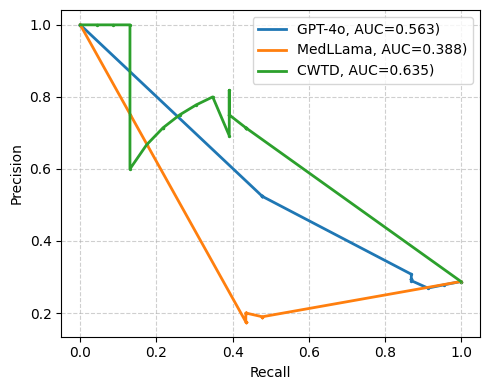

In [222]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc


def pr_at_thresholds_like_sklearn(y_true, y_scores, thresholds, add_anchor=True):
    """
    Compute precision/recall at given thresholds, mimicking sklearn's
    precision_recall_curve conventions.

    - precision = 1.0 when TP + FP = 0 (no positive predictions)
    - optional initial anchor point with recall = 0, precision = 1
      (threshold above max(score)).
    """
    y_true = np.asarray(y_true).astype(int)
    y_scores = np.asarray(y_scores).astype(float)
    thresholds = np.asarray(thresholds, dtype=float)

    precs = []
    recs = []
    used_thresholds = []

    # Anchor point: threshold higher than any score (like sklearn)
    if add_anchor:
        t_anchor = y_scores.max() + 1e-12
        thresholds = np.concatenate(([t_anchor], thresholds))

    for t in thresholds:
        y_pred = (y_scores >= t)

        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        fn = np.sum((y_pred == 0) & (y_true == 1))

        # sklearn convention for undefined precision (no positive predictions)
        if tp + fp == 0:
            precision = 1.0
        else:
            precision = tp / (tp + fp)

        # standard recall
        if tp + fn == 0:
            recall = 0.0
        else:
            recall = tp / (tp + fn)

        precs.append(precision)
        recs.append(recall)
        used_thresholds.append(t)

    precs = np.asarray(precs)
    recs = np.asarray(recs)
    used_thresholds = np.asarray(used_thresholds)

    # Sort by recall so auc(recall, precision) works as expected
    order = np.argsort(recs)
    return precs[order], recs[order], used_thresholds[order]


def plot_pr_curves(df, score_columns, ground_truth_col='omim_binary',
                   manual_thresholds=None):
    """
    Plots Precision–Recall curves for multiple models and shows their AUCs.

    If manual_thresholds is None:
        Uses sklearn.metrics.precision_recall_curve (full curve).
    Else:
        Uses pr_at_thresholds_like_sklearn with the given thresholds.
    """
    plt.figure(figsize=(5, 4))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig('PR_curve_PD')
    
    display_names = {
        'score': 'GPT-4o',
        'medllama_score': 'MedLLama',
        'vq*': 'CWTD'
    }

    for col in score_columns:
        if col not in df.columns:
            print(f"Column {col} not in DataFrame, skipping.")
            continue

        # Drop rows with NaNs in either the score or the ground truth
        mask = df[col].notna() & df[ground_truth_col].notna()
        if mask.sum() == 0:
            print(f"Skipping {col} — no valid data.")
            continue

        y_true = df.loc[mask, ground_truth_col].astype(int).values
        y_scores = df.loc[mask, col].astype(float).values

        # Compute PR curve
        if manual_thresholds is None:
            precision, recall, _ = precision_recall_curve(y_true, y_scores)
        else:
            precision, recall, _ = pr_at_thresholds_like_sklearn(
                y_true, y_scores, manual_thresholds, add_anchor=True
            )

        pr_auc = auc(recall, precision)
        label_name = display_names.get(col, col)

        # Line
        plt.plot(recall, precision, linewidth=2,
                 label=f"{label_name}, AUC={pr_auc:.3f})")

        # Optional: show discrete points when manual thresholds are used
        if manual_thresholds is not None:
            plt.scatter(recall, precision, s=2)

    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


# ============================
# Example usage
# ============================

# Remove duplicate genes (by id1), keep first occurrence
# df_prepared = df_prepared.drop_duplicates(subset='id1', keep='first')

#cols_to_test = ['score', 'medllama_score', 'vq*']

# 1. Collect all unique thresholds from the 3 models
all_thresholds = pd.concat([
    df_prepared['score'].dropna(),
    df_prepared['medllama_score'].dropna(),
    df_prepared['vq*'].dropna(),
]).unique()

# 2. Sort thresholds (sklearn PR logic expects thresholds high→low)
manual_thresholds = np.sort(all_thresholds)[::-1]
# manual_thresholds = np.linspace(0,1,100)
print("Number of unique thresholds:", len(manual_thresholds))
df_filtered = df_prepared[df_prepared['total'] >= 2].copy()

# 3. Plot PR curves using actual model score cutoffs
plot_pr_curves(
    df_filtered,
    cols_to_test,
    ground_truth_col='omim_binary',
    manual_thresholds=manual_thresholds
)


In [126]:
df_omim_comp = pd.read_csv('truth_discovery/PD_OMIM_complete_data')
df_omim_comp.columns

Index(['Unnamed: 0', 'index', 'id1', 'id2', 'is_in_same_sent',
       'min_sents_window', 'sentence', 'in_neighbors', 'label', 'Prediction',
       'journal', 'hindex', 'Symbol', 'year', 'citations', 'year_diff',
       'citations_scaled', 'hindex_scaled', 'rs', 'vq*'],
      dtype='object')

In [133]:
# Count Prediction == 1
pred1 = (
    df_omim_comp
    .groupby(['id1', 'id2'])['Prediction']
    .apply(lambda x: (x == 1).sum())
    .reset_index(name='number_of_causal')
)

# Count total rows for each id1,id2
total = (
    df_omim_comp
    .groupby(['id1', 'id2'])
    .size()
    .reset_index(name='total')
)

df_prepared = (
    df_prepared
    .merge(pred1, on=['id1', 'id2'], how='left')
    .merge(total, on=['id1', 'id2'], how='left')
)

In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def recall_at_k_curve(df, score_cols, ground_truth_col='omim_binary',
                      k_values=None, display_names=None,
                      min_total_count=0):
    """
    Compute and plot Recall@K curves for multiple model score columns.
    Only uses rows where total_count >= min_total_count.
    """

    # ------------------------------
    # NEW: filter by total_count >= min_total_count
    # ------------------------------
    if 'total' not in df.columns:
        raise ValueError("df must contain 'total_count' column")

    df = df[df['total'] >= min_total_count].copy()
    # ------------------------------

    plt.figure(figsize=(6,4))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlabel("K")
    plt.ylabel("Recall@K")
    if k_values is None:
        k_values = np.arange(1, min(200, len(df)) + 1)

    if display_names is None:
        display_names = {col: col for col in score_cols}

    total_positives = df[ground_truth_col].sum()

    for col in score_cols:
        if col not in df.columns:
            print(f"Column {col} missing, skipping.")
            continue

        mask = df[col].notna() & df[ground_truth_col].notna()
        df_valid = df.loc[mask].copy()

        df_valid = df_valid.sort_values(col, ascending=False)

        recalls = []
        for k in k_values:
            topk = df_valid.head(k)
            tp_at_k = topk[ground_truth_col].sum()
            recall = tp_at_k / total_positives if total_positives > 0 else 0
            recalls.append(recall)

        plt.plot(k_values, recalls, linewidth=2,
                 label=display_names.get(col, col))

    plt.legend()
    plt.tight_layout()
    plt.savefig("Recall_curve_PD")
    plt.show()
    


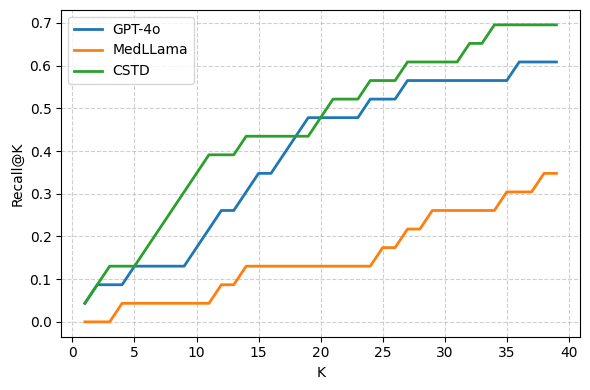

In [239]:
score_columns = ['score', 'medllama_score', 'vq*']

display_names = {
    'score': 'GPT-4o',
    'medllama_score': 'MedLLama',
    'vq*': 'CSTD'
}

k_values = np.arange(1, 40)

recall_at_k_curve(
    df_prepared,
    score_columns,
    ground_truth_col='omim_binary',
    k_values=k_values,
    display_names=display_names,
    min_total_count=2      # <-- FILTER APPLIED HERE
)


In [237]:
def plot_pr_curves(df, score_columns, ground_truth_col='omim_binary',
                   manual_thresholds=None):
    """
    Plots Precision–Recall curves for multiple models and shows their AUCs.
    """
    plt.figure(figsize=(5, 4))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True, linestyle='--', alpha=0.6)
    
    display_names = {
        'score': 'GPT-4o',
        'medllama_score': 'MedLLama',
        'vq*': 'CSTD'
    }

    # ============================================
    # NEW BASELINE CALCULATION
    # ============================================
    positive_rate = df[ground_truth_col].mean()  # prevalence
    plt.axhline(
        y=positive_rate,
        linestyle='--',
        color='black',
        linewidth=1.5,
        label=f'Baseline'
    )
    # ============================================

    for col in score_columns:
        if col not in df.columns:
            print(f"Column {col} not in DataFrame, skipping.")
            continue

        mask = df[col].notna() & df[ground_truth_col].notna()
        if mask.sum() == 0:
            print(f"Skipping {col} — no valid data.")
            continue

        y_true = df.loc[mask, ground_truth_col].astype(int).values
        y_scores = df.loc[mask, col].astype(float).values

        if manual_thresholds is None:
            precision, recall, _ = precision_recall_curve(y_true, y_scores)
        else:
            precision, recall, _ = pr_at_thresholds_like_sklearn(
                y_true, y_scores, manual_thresholds, add_anchor=True
            )

        pr_auc = auc(recall, precision)
        label_name = display_names.get(col, col)

        plt.plot(
            recall,
            precision,
            linewidth=2,
            label=f"{label_name} (AUC={pr_auc:.3f})"
        )

        if manual_thresholds is not None:
            plt.scatter(recall, precision, s=2)

    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig('PR_curve_PD')
    plt.show()


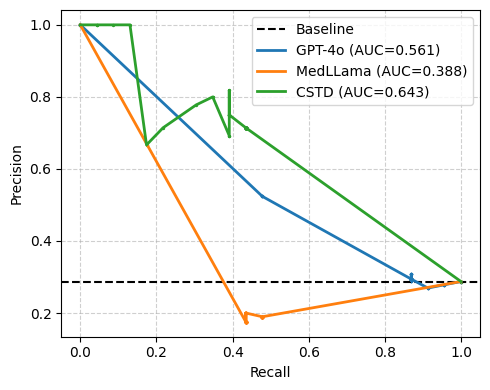

In [238]:
df_prepared = df_prepared.drop_duplicates(subset='id1', keep='first')

cols_to_test = ['score', 'medllama_score', 'vq*']

manual_thresholds = np.linspace(0,1,100)

df_filtered = df_prepared[df_prepared['total'] >= 2].copy()

plot_pr_curves(
    df_filtered,
    cols_to_test,
    ground_truth_col='omim_binary',
    manual_thresholds=manual_thresholds
)


In [235]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

def generate_classification_reports(df, score_columns, threshold=0.9,
                                    ground_truth_col='omim_binary',
                                    min_total_count=0):
    """
    Prints the full sklearn classification report for multiple models at a specific threshold.
    Evaluates ONLY rows where total_count >= min_total_count.
    """

    # -----------------------------------------
    # NEW: Filter by total_count >= min_total_count
    # -----------------------------------------
    if 'total' not in df.columns:
        raise ValueError("df must contain 'total_count' column.")

    df = df[df['total'] >= min_total_count].copy()
    # -----------------------------------------

    print(f"\nUsing only id1,id2 pairs with total_count >= {min_total_count}")
    print(f"Remaining rows = {len(df)}")

    print(f"\n{'='*60}")
    print(f"CLASSIFICATION REPORT @ THRESHOLD {threshold}")
    print(f"{'='*60}")

    valid_cols = [c for c in score_columns if c in df.columns]

    for col in valid_cols:

        mask = df[col].notna() & df[ground_truth_col].notna()
        if mask.sum() == 0:
            print(f"Skipping {col} (No valid data)")
            continue

        y_true = df.loc[mask, ground_truth_col]
        y_scores = df.loc[mask, col]

        if y_scores.max() > 1.0 and threshold < 1.0:
            print(f"\n[WARNING] '{col}' max value is {y_scores.max()}.")
            print(f"           Threshold {threshold} might be too low. Did you mean 90?")

        y_pred = (y_scores >= threshold).astype(int)

        report = classification_report(
            y_true, y_pred,
            target_names=['Not OMIM (0)', 'OMIM (1)'],
            zero_division=0
        )

        display_names = {
            'score': 'GPT-4o',
            'medllama_score': 'MedLLama',
            'vq*': 'CWTD'
        }

        print(f"\n--- Model: {display_names[col]} ---")
        print(report)


In [236]:
cols_to_test = ['score', 'medllama_score', 'vq*']

# df_prepared = prepare_data(df)
# df_prepared = df_prepared.drop_duplicates(subset='id1', keep='first')

# Evaluate only pairs with >= 5 supporting sentences
generate_classification_reports(
    df_prepared,
    cols_to_test,
    threshold=0.9,
    min_total_count=2
)



Using only id1,id2 pairs with total_count >= 2
Remaining rows = 80

CLASSIFICATION REPORT @ THRESHOLD 0.9

--- Model: GPT-4o ---
              precision    recall  f1-score   support

Not OMIM (0)       0.80      0.21      0.33        57
    OMIM (1)       0.31      0.87      0.45        23

    accuracy                           0.40        80
   macro avg       0.55      0.54      0.39        80
weighted avg       0.66      0.40      0.37        80


--- Model: MedLLama ---
              precision    recall  f1-score   support

Not OMIM (0)       0.43      0.18      0.25        57
    OMIM (1)       0.18      0.43      0.25        23

    accuracy                           0.25        80
   macro avg       0.31      0.31      0.25        80
weighted avg       0.36      0.25      0.25        80


--- Model: CWTD ---
              precision    recall  f1-score   support

Not OMIM (0)       0.79      0.95      0.86        57
    OMIM (1)       0.75      0.39      0.51        23

    ac